# Pre-Processing in GeoConv: GPC-systems

The `preprocess_demo.py` file contains an entire example pipeline on how to pre-process triangle meshes such that we can propagate them into an intrinsic mesh CNN. After normalizing the triangle mesh, we compute **Geodesic Polar Coordinate Systems** (**GPC-systems**):

```
gpc_systems = compute_gpc_systems(bunny, u_max=u_max, tqdm_msg="Computing GPC-systems", use_c=True)
```

The goal of this tutorial is to explain why we need GPC-systems and how we compute aswell as visualize them with GeoConv.

## Why do we need Geodesic Polar Coordinate Systems?

When we talk about (spatial) convolutions we always consider some **signal** in some domain and a **template**, which is used to transform our signal. For example, intrinsic surface convolution compute the convolution as follows [1]:

$$
(s \ast t)(\textbf{u}) = \underset{B_R(\textbf{0})}{\int} t(\textbf{v}) [D_w(\textbf{u})s](\textbf{v}) d\textbf{v}
$$

Thereby, $t(\cdot)$ represents a template and the patch operator $[D_w(\textbf{u})s](\cdot)$ our signal.

Let's say we have a continuous two-dimensional compact Riemannian manifold $M^2$ (surface) as our domain and a continuous **signal** function $s: M^2 \rightarrow \mathbb{R}$ defined "on top of" the surface. In a discrete setting, we approximate $M^2$ with a triangle mesh that has a finite set of vertices $\mathbb{V}$. Consequently, our signal function can only be defined on that set of vertices $s: \mathbb{V} \rightarrow \mathbb{R}$. In such a discrete setting it also does not pose a problem to associate a vector instead of a scalar with each vertex $\mathbb{v}_k \in \mathbb{V}$. Hence, assume $s: \mathbb{V} \rightarrow \mathbb{R}^n$. In practice, we can therefore define $s$ as a matrix $\textbf{S} \in \mathbb{R}^{|\mathbb{V}| \times n}$.

The (trainable) weights of a "*intrinsic surface convolution*"-layer are contained in the **template** $t(\cdot)$. Obviously, in practice we have to discretize $t(\cdot)$ into something finite. For this, we define so called *template vertices* $\mathbb{T} = \{\rho_i\}_{i=0}^{N_\rho} \times \{\theta_j\}_{j=0}^{N_\theta}$ with $\rho_i = (i+1)\rho_\text{max}/N_\rho$ and $\theta_j = 2j\pi / N_\theta$ for $i, j > 0$ and $\rho_{\text{max}} \in \mathbb{R}$ some maximal radius. That is, the template vertices are defined at specific locations which are described in (geodesic) polar coordinates. Visually, the template looks like this:

In [1]:
from geoconv.preprocessing.barycentric_coordinates import create_template_matrix
from matplotlib import pyplot as plt

import ipywidgets as widgets

@widgets.interact(N_rho=(0, 10), N_theta=(0, 20), rho_max=(0.1, 2.))
def f(N_rho=5, N_theta=8, rho_max=1.):
    template_vertices = create_template_matrix(n_radial=N_rho, n_angular=N_theta, radius=rho_max, in_cart=False)
    fig = plt.figure()
    ax = fig.add_subplot(projection='polar')
    ax.scatter(template_vertices.reshape(-1, 2)[:, 1], template_vertices.reshape(-1, 2)[:, 0])

interactive(children=(IntSlider(value=5, description='N_rho', max=10), IntSlider(value=8, description='N_theta…

Figuratively speaking, when computing a surface convolution, we "lay" $\mathbb{T}$ onto the surface, just as we to "lay" a template onto an image when computing (spatial) Euclidean convolutions. Due to that, we implicitly consider "local surface patches", or a "local surface area" beneath the template.

> After laying the discretized template onto the surface, where is each template vertex located on the surface?

This question is central because we need to know which signal values from the surface correspond to which learned weight of the template.
Hence, we need a tool that describes local surface structure in the same way in which we describe our discretized template. To phrase it more precise, we need a *common domain* for the template and local surface patches. GPC-systems locally describe the relative positions among surface points with the help of geodesic polar coordinates:

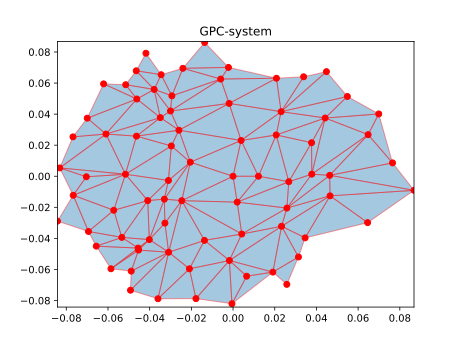

In [6]:
from IPython.display import SVG, display
display(SVG("./gpc_system.svg"))

Here, the red dots represent vertices of a triangle mesh. In the plot, their geodesic polar coordinates have already been translated into cartesian coordinates. The reason for this should not bother us for now and will become evident later.

Given the GPC-systems, we not only describe template vertices in geodesic polar coorinates, but also the mesh vertices. Hence, with the GPC-systems we have a common domain for template vertices and mesh vertices. Figuratively speaking, we can "lay" both the GPC-system and the template vertices in the same domain:

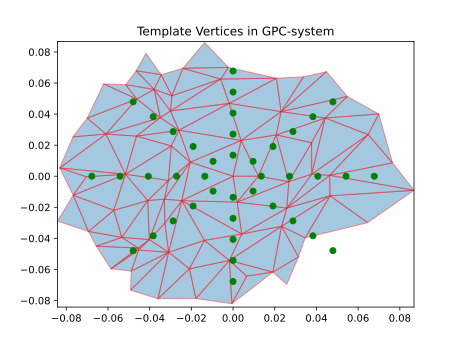

In [21]:
from IPython.display import SVG, display
display(SVG("./template_in_gpc_system.svg"))

We can now determine where a template vertex lies on the surface by doing two things:
1. Find the triangle in which the template vertex lies
2. Describe the template vertex with the help of the triangle's vertices and [barycentric coordinates](https://en.wikipedia.org/wiki/Barycentric_coordinate_system#Barycentric_coordinates_on_triangles)

In conclusion, we need GPC-systems as a means to get a common domain for local surface patches and the template so that we can accurately determine where the template vertices are located on the surface.

## Prepare your data

For this tutorial you need to download the Stanford Bunny from here:

    https://github.com/alecjacobson/common-3d-test-models/blob/master/data/stanford-bunny.zip

Unzip the file and move write the path to the `bun_zipper.ply`-file into the `bunny_path`-variable:

In [9]:
from geoconv.utils.misc import normalize_mesh

import open3d as o3d
import trimesh

# TODO
bunny_path = "/home/andreas/Uni/Projects/geoconv/geoconv/examples/stanford_bunny/bun_zipper.ply"

# Load and normalize the triangle mesh
bunny = o3d.io.read_triangle_mesh(bunny_path)
bunny = bunny.simplify_quadric_decimation(target_number_of_triangles=6000)
bunny = trimesh.Trimesh(vertices=bunny.vertices, faces=bunny.triangles)
normalized_bunny, geodesic_diamter = normalize_mesh(bunny, geodesic_diameter=None)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3040/3040 [01:07<00:00, 44.93it/s, Calculating geodesic diameter..]

-> Normalized with geodesic diameter: 0.25270776231631265


## Theoretical Background on Surface Patches

Above we already mentioned the *patch opeartor* $[D_w(\textbf{u})s](\textbf{v})$. Combining the theory about intrinsic surface convolutions from [1] with the framework for non-Euclidean convolutions proposed in [2] allows us to define the patch operator as:

$$
[D_w(\textbf{u})s](\textbf{v}) = \underset{B_R(\textbf{0})}{\int} w_\textbf{v}(\textbf{y})[s \circ \text{exp}_\textbf{u} \circ \omega_\textbf{u}](\textbf{y})\ d\textbf{y}
$$

The patch operator's goal is to **interpolate and extract local surface information** which can be used within the intrinsic surface convolution. It contains three main components:
- A signal $s(\cdot)$
- A prior $w_\bullet(\cdot)$
- A patch $[\text{exp}_\bullet \circ \omega_\bullet](\cdot)$

### The signal

In practice we can approximate continuous surfaces with triangle meshes. In doing so, we restrict the signal $s(\cdot)$ to be defined on the mesh's vertices. The selection of an appropriate signal is up to the user. The literature typically uses shape descriptors such as *SHOT descriptors* [2, 3] or *optimal shape desriptors* [4, 5]. Our experiments have shown that normalized 3D coordinates can also be used.

### The prior

The patch operator does not simply extract a signal value at a point on the surface. It *interpolates* the signal at a point of interest. For this, we need to define some sort of interpolation coefficients. Interpolation coefficients tell how much neighboring vertices contribute to the signal at the point of interest. That is, given a point of interest $\textbf{y}$, $w_\bullet(\textbf{y})$ defines a function that tells how much neighboring vertices contribute additionally to the surface signal at $\textbf{y}$. A good choice should pay attention to local surface structure, which can be considered *prior information*. Hence the name. The literature typically uses priors that are proportional to the normal distribution [2, 4, 6]. However, you're not restricted to normal distributions. GeoConv allows you to define arbitrary priors. But this exceeds the scope of this tutorial.

### The patch

A patch $[\text{exp}_\textbf{u} \circ \omega_\textbf{u}](\cdot)$ can simply be thought of as an *extracted local area element* of the triangle mesh with center vertex $\textbf{u}$. Let's take a closer look on the *frame* (or gauge) $\omega_\textbf{u}$ and the *exponential map* $\text{exp}_\textbf{u}$.

> *A short side-note to avoid confusion:* The exponential map is not meant as in "*e to the power of ...*". It is a local diffeomorphism $\text{exp}_\textbf{u}: T_\textbf{u} M^n \rightarrow M^n$ from a tangent space to the underlying manifold. This mapping appears a lot in differential geometry.

For the Euclidean convolution on images we need to know the relative positions between image pixels. These are simply given by subtracting the indices (or coordinates) of the pixels. When working with meshes, we use *tangent vectors* as a local notion for relative positions between surface points since subtraction for surface points is not defined. However, tangent vectors are coordinate free in general. This is why we are required to define *some* frame $\omega_\textbf{u}$ that associates coordinates with tangent vectors and has its origin in surface point $\textbf{u}$. Be aware that there is no unique frame in general. For example, a chosen frame can be arbitrarly rotated and each rotation yields another frame which adequatly describes local surface information. This ambiguity problem is often times referred to as **angular coordinate ambiguity** [1, 2, 4, 6].

Given a frame $\omega_\textbf{u}$ centered in surface point $\textbf{u}$, we can map a tangent vector $\omega_\textbf{u}(\textbf{y})$ onto a surface point with the exponential map $\text{exp}_\textbf{u}(\omega_\textbf{u}(\textbf{y}))$. The exponential map is limited by the so called **injectivity radius** $R$. Surface points which lie farther than $R$ to the origin will be mapped on coordinates which are already assigned to other surface points.

In practice, we select a mesh vertex $\textbf{v}_k$ and compute *geodesic polar coordinates* $(\rho, \theta)$ for all triangle mesh vertices $\textbf{v}_l$ which have a maximal geodesic distance of $\rho_{\text{max}}$ to $\textbf{v}_k$. We refer to the set of all computed coordinates for a center vertext $\textbf{v}_k$ as a *local geodesic polar coordinate system* (**GPC-system**). The computation of a GPC-system can be done in multiple ways. For example, [4] uses a modified fast marching method. GeoConv, in contrast, implements the algorithm of [7] (if you're intersted, check `compute_gpc_systems`).

> That is, if we want to retrieve mesh vertex $\text{exp}_{\textbf{v}_k}(\omega_{\textbf{v}_k}(\rho, \theta))$ we "enter" the pre-computed coordinates $(\rho, \theta)$ into the GPC-system that has its center in $\textbf{v}_k$.

## How to compute GPC-systems

From the theory we know that we must consider the following two aspects to avoid computing degenerated GPC-systems:
1. **Injectivity Radius**: The injectivity radius is the maximal extension of a local GPC-system
2. **Angular Coordinate Ambiguity**: The angular coordinate ambiguity refers to the ambiguity in the selection of a reference direction within a local GPC-system. Where is 0° in our GPC-system?

GeoConv provides you with the necessary algorithms and data structures to compute the GPC-systems. While the provided functions take care of defining a reference direction, which alleviates from thinking about the *angular coordinate ambiguity problem*, you still need to think about what maximal radius your GPC-systems can have. Here are two "rules" that you should consider when elaborating on that question:
1. The maximal radius should not be **smaller** then the **largest** one-hop neighborhood distance of the vertices from your normalized mesh
2. The maximal radius should not be **larger** then the **smallest** injectivity radius of your normalized meshes

In practice, we use the following rule of thumb:
- Let the largest one-hop neighborhood distance in your dataset of **all** meshes be given by $r$
- Set the maximal radius for **all** GPC-systems to: $R = r * \alpha$ for $\alpha > 1$

While definetly not being a perfect choice, this ensures that you will not violate the first rule. However, be aware that you might get degenerate GPC-systems in meshes at places where $R$ exceeds the injectivity radius.

The following code-box calculates multiple GPC-systems of different size for a single origin. Configure `vertex_idx`, `amt_alphas` and `largest_alpha` yourself.
- `vertex_idx`: Determines the origin of the local coordinate system on the mesh
- `amt_alphas`: Determines how many alpha are computed
- `largest_alpha`: Determines the size of the largest GPC-system

In [11]:
from geoconv.utils.misc import find_largest_one_hop_dist
from geoconv.preprocessing.discrete_gpc import local_gpc
from geoconv.utils.visualization import draw_gpc_on_mesh, draw_gpc_triangles

import matplotlib
import numpy as np
import os

# Configure here! #
vertex_idx = 500  #
amt_alphas = 20   #
largest_alpha = 2.#
###################

# Create directory for images
image_dir = f"{os.path.dirname(bunny_path)}/gpc_images"
if not os.path.exists(image_dir):
    os.makedirs(image_dir)

r = find_largest_one_hop_dist(normalized_bunny)
all_alphas = np.linspace(1., largest_alpha, amt_alphas)
for idx, alpha in enumerate(all_alphas):
    # Calculate GPC-system radius
    R = r * alpha

    # Calculate one GPC-system
    radial_coordinates, angular_coordinates, _ = local_gpc(vertex_idx, R, normalized_bunny, use_c=True)

    # Visualization
    draw_gpc_on_mesh(
        vertex_idx,
        radial_coordinates,
        angular_coordinates,
        normalized_bunny,
        save_name=f"{image_dir}/bunny_gpc_system_{idx}",
        angles=(0., 0., 0.),  # Camera setting
        distance=.9,  # Camera setting
        center=(0., 0., 0.)  # Camera setting
    )
    draw_gpc_triangles(
        normalized_bunny,
        vertex_idx,
        u_max=R,
        print_scatter=False,
        plot=False,
        title="GPC-system in 2D",
        save_name=f"{image_dir}/2d_gpc_system_{idx}.png"
    )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3040/3040 [00:03<00:00, 828.47it/s, Determining largest one-hop neighborhood distance..]


**Check your results** with the following code-box. In the top row you see the GPC-systems illustrated directly on the Stanford Bunny in the 3-dimensional space.
- The **red** colors indicate the **radial** distance from the origin (darker means larger)
- The **green** colors indicate the **angular** distance from the reference direction (darker means larger)

In the lower row you see **the same** GPC-system but in 2D. Ihe moment the blue appears darker, you overstepped the injectivity radius. We generally try to avoid that case.

In [12]:
from PIL import Image
from matplotlib.gridspec import GridSpec

import ipywidgets as widgets
import matplotlib.pyplot as plt

@widgets.interact(alpha=(0, amt_alphas-1))
def f(alpha=0):
    # Load pre-computed images
    radial_coordinates_3d = Image.open(f"{image_dir}/bunny_gpc_system_{alpha}_radial_coords.png")
    angular_coordinates_3d = Image.open(f"{image_dir}/bunny_gpc_system_{alpha}_angular_coords.png")
    gpc_system_2d = Image.open(f"{image_dir}/2d_gpc_system_{alpha}.png")

    # Configure plot
    fig = plt.figure(layout="constrained", figsize=(15, 11))

    gs = GridSpec(2, 2, figure=fig)
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(radial_coordinates_3d)
    # ax1.axis("off")
    
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(angular_coordinates_3d)
    # ax2.axis("off")

    ax3 = fig.add_subplot(gs[1, :])
    ax3.imshow(gpc_system_2d)
    ax3.axis("off")

    fig.suptitle(f"Local GPC-system with 'alpha = {all_alphas[alpha]:.3f}'")
    plt.show()

interactive(children=(IntSlider(value=0, description='alpha', max=19), Output()), _dom_classes=('widget-intera…

### How GPC-systems are stored

In practice, we need a GPC-system for every vertex. In orther words, each vertex once has to be the origin of a GPC-system. Conveniently, GeoConv equips you with a wrapper function that does exactly that (-> `compute_gpc_systems`).

In [13]:
from geoconv.preprocessing.discrete_gpc import compute_gpc_systems

from pathlib import Path

alpha = 1.1
R = r * alpha
bunny_path_gpc = f"{os.path.dirname(bunny_path)}/bunny_gpc_systems.npy"
if not Path(bunny_path_gpc).is_file():
    gpc_systems = compute_gpc_systems(normalized_bunny, u_max=R, tqdm_msg="Computing GPC-systems", use_c=True)
    np.save(bunny_path_gpc, gpc_systems)
else:
    gpc_systems = np.load(bunny_path_gpc)

print(f"Result shape of GPC-system array: {gpc_systems.shape}")
print(f"That is, we have {gpc_systems.shape[0]} GPC-systems in total, for our mesh that has {gpc_systems.shape[1]} vertices.")

Result shape of GPC-system array: (3040, 3040, 2)
That is, we have 3040 GPC-systems in total, for our mesh that has 3040 vertices.


Here, the `gpc_systems` contains all GPC-systems. It always follows the following structure:
1. Dimension: `gpc_systems[i]` returns the $i$-th GPC-system
2. Dimension: `gpc_systems[i, j]` returns the geodesic coordinates of the $j$-th vertex of the mesh in the $i$-th GPC-system. Note that vertices that are not included in the GPC-system default to have $[\infty\ -1]$ as geodesic polar coordinates
3. Dimension: `gpc_systems[i, j, 0]` returns a radial coorodinate (geodesic distance); `gpc_systems[i, j, 1]` returns an angular coordinate

### How to visualize GPC-systems

You can visualize your GPC-systems by determining the contained triangles with `determine_gpc_triangles` and feeding the triangles into `draw_triangles`:

In [14]:
from geoconv.utils.misc import gpc_systems_into_cart

# `draw_triangles` requires Cartesian coordinates
gpc_systems_cart = gpc_systems_into_cart(gpc_systems)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3040/3040 [00:09<00:00, 316.95it/s, Translating GPC-coordinates into cartesian]


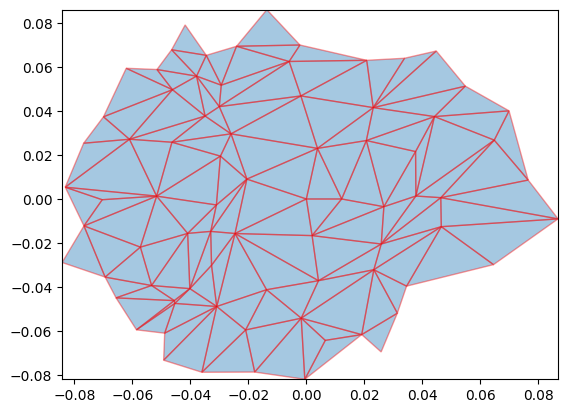

In [15]:
from geoconv.preprocessing.barycentric_coordinates import determine_gpc_triangles
from geoconv.utils.visualization import draw_triangles

# Select GPC-system, that shall be visualized
gpc_system_idx = 0

# Determine triangles contained in the `gpc_systems_cart[gpc_system_idx]` with the help of the mesh
triangles, triangle_indices = determine_gpc_triangles(normalized_bunny, gpc_systems_cart[gpc_system_idx])

# Draw GPC-system
draw_triangles(triangles)

Alternatively, you can use the wrapper function `draw_gpc_triangles` which computes the GPC-system in a selected vertex for a given mesh with a given max radius internally and visualizes it subsequently:

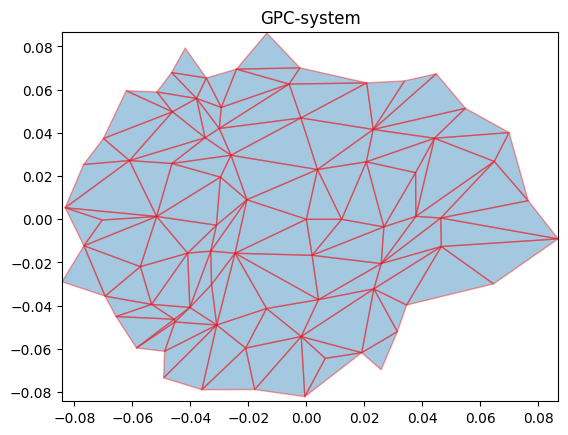

(3040, 2)


In [16]:
from geoconv.utils.visualization import draw_gpc_triangles

vertex_idx = 0
alpha = 1.1
R = r * alpha
one_gpc_system = draw_gpc_triangles(
    normalized_bunny,
    vertex_idx,
    u_max=R,
    print_scatter=False,  # Put dots at the triangle vertices
    plot=True,  # Plot the image
    title="GPC-system",  # Title of the Image
    save_name=f"./2d_gpc_system_{idx}.svg"  # If a `save_name` is given, the image will be saved. Otherwise it wont.
)
print(one_gpc_system.shape)

Lastly, you can use `draw_gpc_on_mesh` to draw the GPC-system in the three-dimensional space directly on the mesh:

In [17]:
from geoconv.utils.visualization import draw_gpc_on_mesh

# Select GPC-system, that shall be visualized
gpc_system_idx = 0

draw_gpc_on_mesh(
    gpc_system_idx,
    gpc_systems[gpc_system_idx, :, 0],  # radial coordinates
    gpc_systems[gpc_system_idx, :, 1],  # angular coorddinates
    normalized_bunny
)

## Summary

We motivated the computation of GPC-system by arguing that we need a common domain for local surface patches and the template so that we can accurately determine where the template vertices are located on the surface.
Subsequently we have discussed how we can use GeoConv for the computation of GPC-systems while considering theoretical implications aswell as showed how we can visualize our results.

At the end of this tutorial, we want to provide a little illustration of how everything discussed works together:

In [20]:
from geoconv.preprocessing.barycentric_coordinates import create_template_matrix
from matplotlib import pyplot as plt

import ipywidgets as widgets

vertex_idx = 0

@widgets.interact(N_rho=(0, 10), N_theta=(0, 20), alpha=(0.1, 2.))
def f(N_rho=5, N_theta=8, alpha=.1):
    R = r * alpha
    template_vertices = create_template_matrix(n_radial=N_rho, n_angular=N_theta, radius=R * 0.75, in_cart=True)
    one_gpc_system = draw_gpc_triangles(
        normalized_bunny,
        vertex_idx,
        u_max=R,
        template_matrix=template_vertices,
        print_scatter=False,  # Put dots at the triangle vertices
        plot=True,  # Plot the image
        title="Template in GPC-system",  # Title of the Image
        save_name=f"./2d_gpc_system_{idx}.svg"  # If a `save_name` is given, the image will be saved. Otherwise it wont.
    )

interactive(children=(IntSlider(value=5, description='N_rho', max=10), IntSlider(value=8, description='N_theta…

## Sources

[1] Bronstein, Michael M., et al. "Geometric deep learning: Grids, groups, graphs, geodesics, and gauges." arXiv preprint arXiv:2104.13478 (2021).

[2] Monti, Federico, et al. "Geometric deep learning on graphs and manifolds using mixture model cnns." Proceedings of the IEEE conference on computer vision and pattern recognition. 2017.

[3] Salti, Samuele, Federico Tombari, and Luigi Di Stefano. "SHOT: Unique signatures of histograms for surface and texture description." Computer Vision and Image Understanding 125 (2014): 251-264.

[4] Masci, Jonathan, et al. "Geodesic convolutional neural networks on riemannian manifolds." Proceedings of the IEEE international conference on computer vision workshops. 2015.

[5] Litman, Roee, and Alexander M. Bronstein. "Learning spectral descriptors for deformable shape correspondence." IEEE transactions on pattern analysis and machine intelligence 36.1 (2013): 171-180.

[6] Boscaini, Davide, et al. "Learning shape correspondence with anisotropic convolutional neural networks." Advances in neural information processing systems 29 (2016).

[7] Melvær, Eivind Lyche, and Martin Reimers. "Geodesic polar coordinates on polygonal meshes." Computer Graphics Forum. Vol. 31. No. 8. Oxford, UK: Blackwell Publishing Ltd, 2012.